# Using machine learning to prioritize NYC middle schools for intervention, with an intent to increase diverse student registrations for the specialized high school admissions test

### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton (W207-4-Summer 2018 Final Project)


Paraphrased from the Kaggle [PASSNYC: Data Science for Good Challenge](https://www.kaggle.com/passnyc/data-science-for-good) overview (June 2018):

## Problem Statement

PASSNYC is a not-for-profit organization dedicated to broadening educational opportunities for New York City's talented and underserved students. In recent years, the City’s specialized high schools - institutions with historically transformative impact on student outcomes - have seen a shift toward more homogeneous student body demographics.  PASSNYC aims to increase the diversity of students taking the Specialized High School Admissions Test (SHSAT). By focusing efforts in underperforming areas that are historically underrepresented in SHSAT registration, we will help pave the path to specialized high schools for a more diverse group of students.

PASSNYC and its partners provide outreach services that improve the chances of students taking the SHSAT and receiving placements in these specialized high schools. The current process of identifying schools is effective, but PASSNYC could have an even greater impact with a more informed, granular approach to quantifying the potential for outreach at a given school. Proxies that have been good indicators of these types of schools include data on English Language Learners, Students with Disabilities, Students on Free/Reduced Lunch, and Students with Temporary Housing.

Part of this challenge is to assess the needs of students by using publicly available data to quantify the challenges they face in taking the SHSAT. The best solutions will enable PASSNYC to identify the schools where minority and underserved students stand to gain the most from services like after school programs, test preparation, mentoring, or resources for parents.

More on [PASSNYC](http://www.passnyc.org/opportunity-explorer/).


## Overview of our approach

We are going to approach this analysis as a classification problem, by defining a class label related to the proportion of students at a school who register for the SHSAT test (ie. we will define "high-registration" schools).  As we will show in our Exploratory Data Analysis, there is a natural break-point around the 75th percentile for registration rate, which is at 38%.  Therefore, schools with a registration rate of 38% or more will be designated as `high_registrations` schools and given a boolean value of '1', while the other ~75% of schools will get a '0'.  We will build models with multiple machine learning algorithms such as LogisticRegression, K-Nearest Neighbors, Random Forests, and Neural Networks to train and predict on this target variable.  We will explore both feature-rich models, as well as models built after feature selection or a dimensionality reduction technique such as PCA, have been used to reduce the number of features in the model.  

For assessing quality of our models, we will use an 80/20 train/test split of our dataset.  We will use K-fold cross-validation within the training set for hyperparameter optimization, and will calculate average accuracy and F1 scores (along with 95% confidence intervals) based on the cross-validation results.  Once hyperparameter optimization is complete, we will run the model against our held-out test set and report accuracy and F1 score.

Following that, we will prioritize schools for PASSNYC engagement based on a combination of attributes such as performance in the model, registration percentage, class size, proportion of Black and Hispanic students, etc, in alignment with the organization's mission.

## Datasets

We joined several datasets together for this project. We focused mainly on data from the 2016-2017 period as predictors for the 2017 SHSAT test, which is taken in the fall. 

### 1. School Explorer 2016

The [2016 School Explorer](https://www.kaggle.com/passnyc/data-science-for-good#2016%20School%20Explorer.csv) dataset was provided by PASSNYC on Kaggle.  It contains key information about every school in NYC such as name, district, location (address and lat/long), grade levels, budget, demographics, and number of students who achieved 4's in Math and ELA testing, by various demographic and economic levels.  It also contains a set of "school quality metrics" such as rigorous instruction rating, collaborative teachers rating, and strong family-community ties rating.

### 2. NYC SHSAT Test Results 2017

The [NYC SHSAT Test Results 2017](https://www.kaggle.com/willkoehrsen/nyc-shsat-test-results-2017/home) dataset contains data from the New York Times Article: ["See Where New York City’s Elite High Schools Get Their Students"](https://www.nytimes.com/interactive/2018/06/29/nyregion/nyc-high-schools-middle-schools-shsat-students.html) by Jasmine Lee published June 29, 2018.  Data was parsed and uploaded to Kaggle by [Richard W DiSalvo](https://www.kaggle.com/rdisalv2).  This dataset contains information on schools with students eligible to take the SHSAT, the number of students who took the test, the number of resulting offers, and a basic demographic percentage of Black/Hispanic students at the school (ie, NOT test-takers).

### 3. NYC Class Size Report 2016-2017

The [2016-2017 NYC Class Size Report](https://www.kaggle.com/marcomarchetti/20162017-nyc-class-size-report) dataset originally came from the [NYC Schools website](http://schools.nyc.gov/AboutUs/schools/data/classsize/classsize_2017_2_15.htm), but is no longer available there.  It was parsed and uploaded to Kaggle by [Marco Marchetti](https://www.kaggle.com/marcomarchetti).  It is a merge of three datasets: "K-8 Avg, MS HS Avg, PTR".  The "MS HS Avg" subset gives the average class size by program, department, and subject for each school.  The "PTR" data gives the pupil-teacher ratio for the school.

### 4. Demographic Snapshot School 2013-2018

This [2013-2018 Demographic Snapshot of NYC Schools](https://data.cityofnewyork.us/Education/2013-2018-Demographic-Snapshot-School/s52a-8aq6) was downloaded directly from the NYC Open Data project. It contains grade-level enrollments for each school from the NY Department of Education.

### 5. Gifted and Talented Schools Lists

New York City also has a set of test-in Gifted & Talented (G&T) programs.  Some are city-wide, and others give preference to students within a particular district.  Data on which schools have these programs was scraped from [insideschools.org](http://insideschools.org).

## Preliminary EDA and Data Cleaning

Each of these datasets required varying degrees of cleaning before they could be joined together.  The EDA and data cleaning was done in separate notebooks, and results saved as CSV files.

1. [School Explorer EDA Notebook](prep_explorer.ipynb)
2. [SHSAT Results & Demographic Snapshot Notebook](prep_shsat_results.ipynb)
3. [Class Size Notebook](prep_class_sizes.ipynb)
4. [Gifted & Talented Web Scraping Script](sel_scrape.py)

Next we load the resulting CSV files in a [Merge Notebook](prep_merge.ipynb) to join our cleaned data into one master dataset, resolve issues with missing values, and save as [combined_data.csv](data_merged/combined_data.csv).

## Highlights of Exploratory Data Analysis

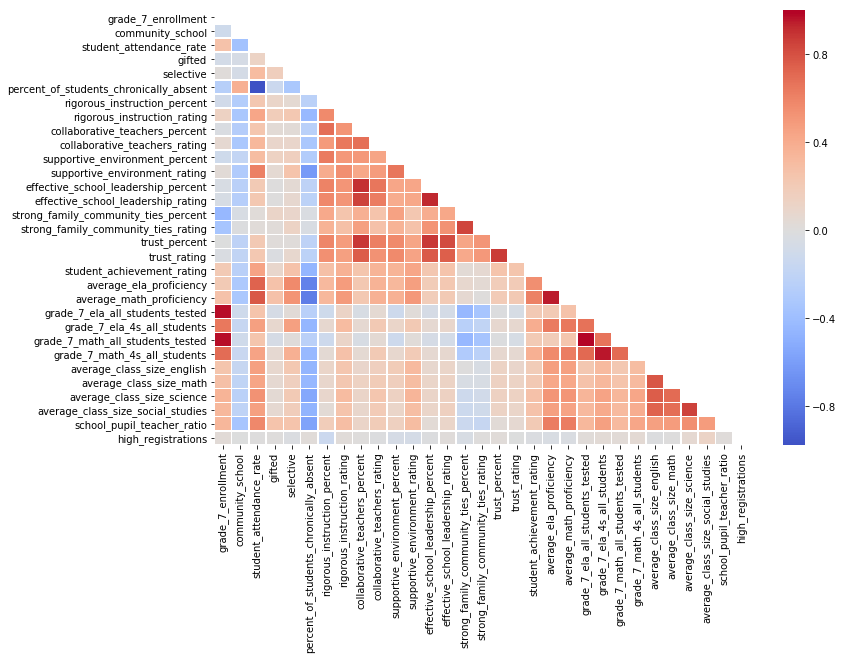

In [1]:
from IPython.display import Image
Image(filename='plots/corr_matrix_key_features.png') 

As discussed in our [EDA notebook](eda_correlation_matrices.ipynb), from this correlation matrix we see that unfortunately most features show almost no correlation with a high SHSAT registration rate (`pct_test_takers`). The `rigorous_instruction_percent` score, as well as the `supportive_environment_percent` score show weak negative correlations with registration rate. Several other features (e.g. average social studies class size) show a very weak positive correlation.  `collaborative_teachers_percent`, effective school leadership, and `trust_percent` are highly correlated between each other. It seems as if they occur together. But they don't seem to have any correlation with high registrations.
 
Academic proficiency (`average_ela_proficiency` and `average_math_proficiency`) is strongly negatively correlated with low attendance schools (`percent_of_students_chronically_absent`). It may be that improving attendance could significantly improve performance. `community_school` is negatively correlated with proficiency. This is probably due to a hidden variable: they are located in neighborhoods that are not conducive for student performance.

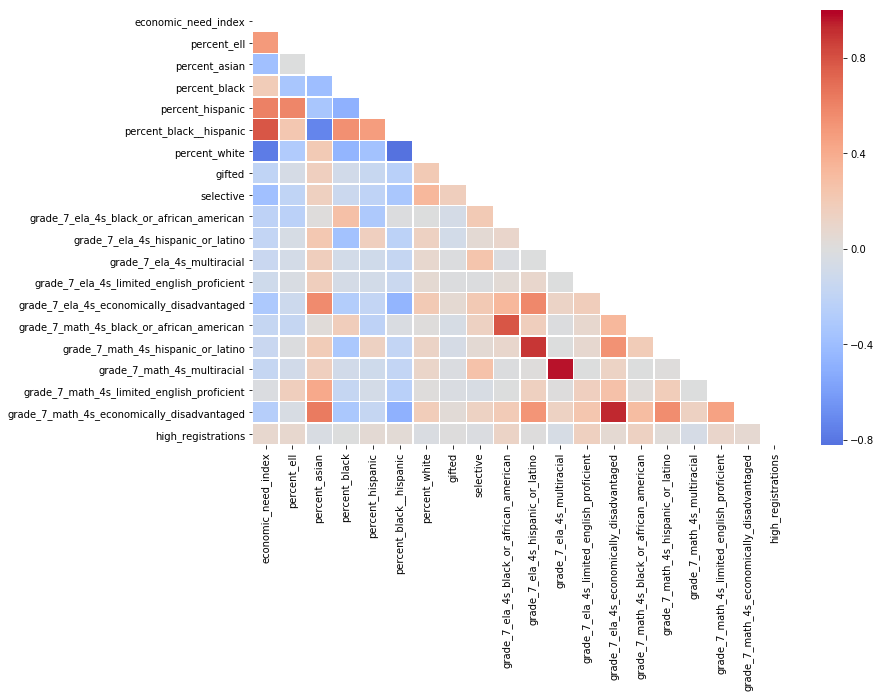

In [2]:
Image(filename='plots/corr_matrix_demographics.png') 

We see that surprisingly, `percent_asian` and `percent_white` have a weak negative correlation with high SHSAT registration rates, whereas `percent_black__hispanic` and `percent_ell` have weak positive correlations with the SHSAT registration rate. Our data also shows significant signs of segregation as can be seen in the negative correlations between races.

It is particularly interesting to note that schools with a high proportion of economically disadvantaged students, limited English proficiency students, and black students scoring 4s on their ELA and Math exams tend to have higher registration rates, as well. This is promising, as it seems to support PASSNYC's mission.

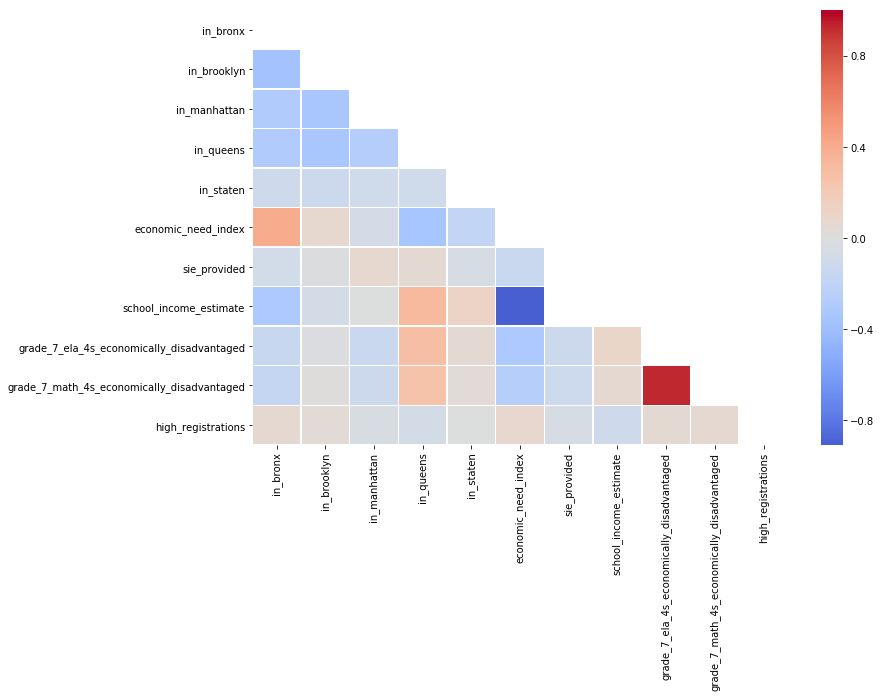

In [3]:
Image(filename='plots/corr_matrix_boroughs.png')

We observe from this correlation matrix that the demographic and economic features in general are not strongly correlated with high SHSAT registration rates.  There are very slight positive correlations for students `in_bronx` or `in_brooklyn`, as well as with the `economic_need_index`.  There is a slight negative correlation with SHSAT registration rate for students `in_queens`.  As such, we expect it will be unlikely that the indicator variables for the boroughs will have strong predictive value.

We also see a negative correlation between `school_income_estimate` and high SHSAT registration rate, but caution that we only have these income estimates for about 1/3 of the schools in our dataset.

## Model Building

Next, we apply a variety of machine learning techniques to determine which provide the best classification results.  Each technique is performed in a separate notebook.  In each case, we also evaluate the effects of using PCA for dimensionality reduction.

1. [K-Nearest Neighbors Model](model_knn.ipynb)
2. [Random Forests](model_forests.ipynb)
4. [Logistic Regression](model_logreg.ipynb)
4. [Neural Network](model_neuralnet.ipynb)

## Summary

Here we summarize the results from each of our models.  Keep in mind that because the class labels are defined as "Top 25th Percentile", any model that does not achieve > 75% accuracy is _no better than a hardcoded model that predicts the negative class naively for **every** observation_.  Since we performed 10-fold cross-validation on each of our models, we also report a 95% confidence interval for both the accuracy and the F1 scores.

Model | CV Accuracy | (95% CI) | CV F1 | (95% CI) | Test Set Accuracy | Test Set F1
:---|:---:|:---:|:---:|:---:|:---:|:---:
K-Nearest Neighbors | 0.849 | (0.721, 0.976) | 0.637 | (0.328, 0.946) | 0.87 | 0.73
Random Forest | 0.846 | (0.766, 0.927) | 0.687 | (0.549, 0.825) | 0.85 | 0.71
Logistic Regression | 0.846 | (0.771, 0.921) | 0.660 | (0.467, 0.853) | 0.88 | 0.72
Mulilayer Perceptron NN | 0.862 | (0.770, 0.956) | 0.675 | (0.422, 0.928) | 0.81 | 0.80

From this it appears that while some models outperform in cross-validation or test-set, accuracy or F1 score, all of the models are quite close to each other.  Since the models have various strengths and weaknesses, and since ensembles in general have better performance than any individual model, we will use a combination of these models for predicting the specific schools we would recommend that PASSNYC engage with.

## Prioritized Engagement Recommendations

### Methodology
Since our dataset contains data for most NYC middle schools already, there is not a large separate, unlabeled dataset that we need to run through our models.  Instead, we will make our recommendations based on an analysis of schools that the models show to have the **highest opportunity to engage with Black and Hispanic students** in order to increase SHSAT registration in this population.  We consider these to be the schools that are most likely to benefit from PASSNYC's intervention and engagement.

In order to estimate this opportunity, we pursued the following steps:
1. Establish a target registration percentage, which is the median percentage of registrations among the "top" registering schools (which we define as above 75th percentile, or higher than ~38% registrations).  This is the median of `pct_test_takers`, obtained from the New York Times dataset.
2. Multiply this target median by `grade_7_enrollment`, obtained from the DOE, to get a number of students in each school who would need to take the test to be a median high-registrant.
3. Subtract `num_shsat_test_takers` (obtained from NY Times) from this number to obtain a delta--the number of students each school is away from its 'target' number (note, for very high performers, this number will be negative).
4. Multiply this delta by `percent_black__hispanic`, obtained from the PASSNYC Explorer dataset, to get a relative measure of the size of the opportunity to engage with the minority population at each school.<sup>1</sup>
5. Once the various models were tuned to our satisfaction, the entire set of 464 schools underwent a Repeated Stratified K-fold cross-validation.  The schools are divided into five parts, the model is trained on four of those parts and then used to predict the answers for the fifth part.  This is repeated five times so every segment gets predicted, and then the whole list is shuffled and the test repeated a total of 10 times, which means each model is run 50 separate times and each school is predicted 10 times.  This is used to generate a positive measure of confidence for each school - if a model predicts a school is high-registering 10 out of 10 times, it gets a score of 100%.  If it predicts a school to be low-registering 10 times, it gets a score of 0%.  This confidence then multiplied by the school's `minority_delta` to obtain a `score`, which represents the overall measure of minority engagement opportunity for each school.<sup>2</sup>
6. The `scores` are then averaged across the four models--K Nearest Neighbors, Logistic Regression, Random Forests, and Multilayer Perceptron--to obtain the final list below.  The resulting schools are the ones that we recommend PASSNYC engage with for the highest anticipated ROI.

<font size='1'><p><sup>1</sup>It is important to note that this number, which we call `minority_delta`, is not a measure of the absolute number of minority students who did not take the test, since we do not know the demographic numbers of students who actually took the test--just the demography of the school at large.  The extent to which the test-taking population does not resemble the larger student body will distort this number.  However, it is the best proxy method we could determine to get a sense of the size of the *opportunity* to engage with a black/hispanic population at a school.</p>

<p><sup>2</sup>Since we are only using this confidence measure on positive predictions, and schools with a high `minority_delta` tend to have low registrations, this mostly results in false positives (ie, schools that the model predicts are high-registering, but aren't).  We do not promote schools that the model is confident are low-registering.  However, a large school with a disproportionately high percentage of black and hispanic students could still be represented, provided their registration numbers were sufficiently below the threshhold.  These schools are marked as `high_registrations` in the final tally.</p></font>

### Top 20 Schools
These are the schools that we recommend PASSNYC consider as its highest-priority for engagement, representing the greatest opportunity for a return on investment in promoting SHSAT registration.

In [4]:
import pandas as pd
# Read final results of each model into separate DataFrames
df_master = pd.read_csv('data_merged/combined_data_2018-07-30.csv')
df_logreg = pd.read_csv('results/results.logreg.csv', index_col=0)
df_knn = pd.read_csv('results/results.knn.csv', index_col=0)
df_neuralnet = pd.read_csv('results/results.neuralnet.csv', index_col=0)
df_randomforest = pd.read_csv('results/results.randomforest.csv', index_col=0)

# Make a new DataFrame of just the scores
df_scores = pd.concat([df_logreg['score'], df_knn['score'], df_neuralnet['score'], df_randomforest['score']], axis=1)
df_scores.columns.values[:4] = ["logreg", "knn", "mlp", "forest"]
# Add a column for the average score
df_scores['avg'] = df_scores.mean(axis=1)
# Return a final listing of schools sorted by average score
df_final = pd.concat([df_master['school_name'], df_master['district'], df_master['percent_black__hispanic'], df_master['grade_7_enrollment'], df_scores], axis=1)
# Add column to denote whether schools were classifed as high-registering
df_final = pd.concat([df_final, df_master['high_registrations']], axis=1)
df_final.sort_values(by='avg', ascending=False, inplace=True)
df_final.insert(0, 'rank', range(1,df_final.shape[0]+1))
df_final.head(20)

,rank,school_name,district,percent_black__hispanic,grade_7_enrollment,logreg,knn,mlp,forest,avg,high_registrations
56,1,J.H.S. 210 ELIZABETH BLACKWELL,27,67,643,53.0,95.4,0.0,53.0,50.350,0
107,2,J.H.S. 278 MARINE PARK,22,63,428,60.8,15.2,7.6,76.0,39.900,0
45,3,I.S. 230,30,57,439,38.0,38.0,38.0,38.0,38.000,0
108,4,I.S. 145 JOSEPH PULITZER,30,90,582,72.0,57.6,0.0,0.0,32.400,0
52,5,M.S. 137 AMERICA'S SCHOOL OF HEROES,27,37,617,50.0,0.0,25.0,50.0,31.250,0
40,6,J.H.S. 220 JOHN J. PERSHING,20,45,473,27.0,27.0,27.0,27.0,27.000,0
59,7,J.H.S. 088 PETER ROUGET,15,71,466,37.1,5.3,10.6,47.7,25.175,1
31,8,I.S. 5 - THE WALTER CROWLEY INTERMEDIATE SCHOOL,24,54,614,27.0,10.8,27.0,27.0,22.950,1
416,9,THE SCHOOL FOR INQUIRY AND SOCIAL JUSTICE,8,96,181,5.1,0.0,25.5,51.0,20.400,0
22,10,J.H.S. 194 WILLIAM CARR,25,31,416,20.0,20.0,20.0,20.0,20.000,0


#### Notes
Concurrence among the models is actually quite high, considering how different their approaches are.  Schools like IS 230 and JHS 220 John J Pershing, which have unanimous scores, represent equivalent confidence from each model (likely 100%), despite having a relatively smaller number of students to engage.  Other schools, such as IS 145 Joseph Pulitzer, demonstrate considerable volatility among the models, and yet score high due to the size of potential engagement--these might warrant closer examination among the models to see which approach resonates most closely with the philosophy of PASSNYC administrators, and get re-weighted accordingly.

## Further Work

As noted in the Methodology section, we believe the biggest assumption--and therefore the greatest weakness--of this approach is the use of whole-school `percent_black__hispanic` demographics as a proxy for test-taking demographics.  Accuracy here would be greatly improved with a description of the students who are actually signing up for the test at each school (if such data exists).

Also helpful would be data from PASSNYC itself, quantifying its success at previous schools.  Given sufficient data on previous engagements, this methodology might be able to more accurately estimate how many students could benefit from PASSNYC's approach.